In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
merged = pd.read_pickle('../dataset/rna-dnam-merge-3class.pkl')
merged.head()

,sample,one_year_r,cg07881041,cg03513874,cg05451842,cg14797042,cg09838562,cg25458538,cg09261072,cg02404579,...,RF00019,AC006380.1,AGR3,RHBDF1P1,GAPDHP67,SKOR2,AC007064.2,MAB21L4,AC006328.1,AL080248.1
0,n366,0,0.967472,0.959952,0.015717,0.986284,0.019557,0.975208,0.686440,0.891883,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.0
1,n350,0,0.958675,0.969429,0.012830,0.990860,0.009751,0.975918,0.718653,0.901881,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.0
2,n355,0,0.958330,0.970704,0.017563,0.988419,0.016279,0.971972,0.691018,0.932405,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000002,0.0
3,n383,0,0.956485,0.971786,0.017026,0.982214,0.014227,0.967617,0.666653,0.900854,...,0.0,0.0,0.0,0.0,0.0,1.800115e-08,0.0,0.0,0.000000,0.0
4,n385,0,0.965497,0.968289,0.015491,0.990840,0.023649,0.968319,0.712608,0.914887,...,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.0


In [3]:
merged = merged.fillna(0)
from sklearn.utils import shuffle
shuffled = shuffle(merged)
#shuffled.to_pickle('../dataset/rna-dnam-merge_shuffled_3class.pkl')
shuffled = pd.read_pickle('../dataset/rna-dnam-merge_shuffled_3class.pkl')

train = shuffled[0:int(0.9*shuffled.shape[0])]
test = shuffled[int(0.9*shuffled.shape[0]):]

labels = np.array(shuffled['one_year_r'])
features = np.array(shuffled.drop(columns=['one_year_r','sample']))
print(labels.shape)
print(features.shape)

train_y = np.array(train['one_year_r'])
train_x = np.array(train.drop(columns=['one_year_r','sample']))
test_y = np.array(test['one_year_r'])
test_x = np.array(test.drop(columns=['one_year_r','sample']))

X = features
Y = labels
print(Y)

(31,)
(31, 769880)
[1 0 1 1 0 1 1 0 1 2 1 0 0 1 0 0 2 1 1 0 0 0 1 2 1 2 0 1 1 0 2]


              precision    recall  f1-score   support

          re       0.50      1.00      0.67         1
         sym       1.00      0.50      0.67         2
         con       1.00      1.00      1.00         1

    accuracy                           0.75         4
   macro avg       0.83      0.83      0.78         4
weighted avg       0.88      0.75      0.75         4



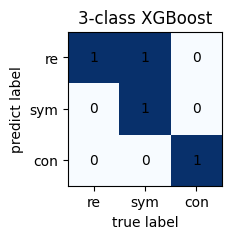

In [4]:
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.utils import class_weight

model_name = 'XGBoost'

clf = xgb.XGBClassifier(n_jobs=-1)
#clf.fit(train_x, train_y, sample_weight=class_weight.compute_sample_weight("balanced", train_y))
clf.fit(train_x, train_y)
result = clf.predict_proba(test_x)
#print(result)
y_pred = np.argmax(result,axis=1)

t = classification_report(test_y, y_pred, target_names=['re', 'sym', 'con'])
print(t)
confusion = confusion_matrix(test_y, y_pred)
ax = plt.figure(figsize=(2, 2))
#ax = sns.heatmap(confusion, fmt='.2f', cmap='Blues', annot=True)
ax = plt.imshow(confusion.T, cmap='Blues')
indices = range(len(confusion))
classes = ['re', 'sym', 'con']
#ax.set_yticklabels(labels=ax.get_yticklabels(), va='center')
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('3-class '  + model_name)

for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index],ha='center',va='center')
        #plt.text(first_index, second_index, np.round(float(confusion[first_index][second_index])/np.sum(confusion[first_index]),2),ha='center')
plt.savefig('../images/rna-dnam-merge-class3/CM_' + model_name,dpi=300, bbox_inches = 'tight')
plt.show()

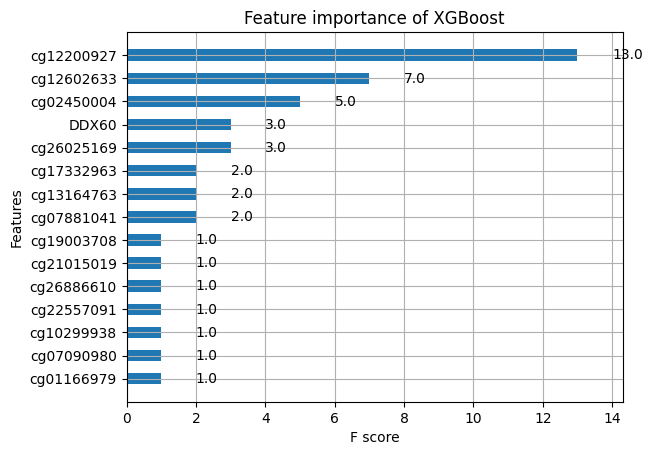

In [5]:
## feature importance
import matplotlib.pyplot as plt
%matplotlib inline

# xgboost
model_name='XGBoost'

import xgboost
clf = xgb.XGBClassifier(n_jobs=-1)
clf.fit(X, Y, sample_weight=class_weight.compute_sample_weight("balanced", Y))
#clf.fit(X, Y)

feature_names = merged.drop(columns=['one_year_r','sample']).columns.values.tolist()
clf.get_booster().feature_names = feature_names
xgboost.plot_importance(clf, height=0.5, max_num_features=15)
plt.title('Feature importance of '  + model_name)
plt.savefig('../images/rna-dnam-merge-class3/feature_' + model_name,dpi=300, bbox_inches = 'tight')
plt.show()

(31,)
(31, 5)
[1 0 1 1 0 1 1 0 1 2 1 0 0 1 0 0 2 1 1 0 0 0 1 2 1 2 0 1 1 0 2]
              precision    recall  f1-score   support

          re       0.50      1.00      0.67         1
         sym       1.00      0.50      0.67         2
         con       1.00      1.00      1.00         1

    accuracy                           0.75         4
   macro avg       0.83      0.83      0.78         4
weighted avg       0.88      0.75      0.75         4



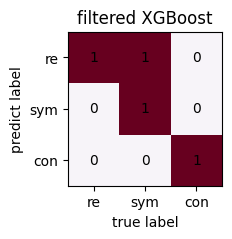

In [7]:
feature5 = shuffled[['cg12200927','cg12602633','cg02450004','DDX60','cg26025169','one_year_r']]

train = feature5[0:int(0.9*feature5.shape[0])]
test = feature5[int(0.9*feature5.shape[0]):]

labels = np.array(feature5['one_year_r'])
features = np.array(feature5.drop(columns=['one_year_r']))
print(labels.shape)
print(features.shape)

train_y = np.array(train['one_year_r'])
train_x = np.array(train.drop(columns=['one_year_r']))
test_y = np.array(test['one_year_r'])
test_x = np.array(test.drop(columns=['one_year_r']))

X = features
Y = labels
print(Y)

import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.utils import class_weight
# , sample_weight=compute_sample_weight("balanced", y)
model_name = 'XGBoost'

clf = xgb.XGBClassifier(n_jobs=-1)
#clf.fit(train_x, train_y, sample_weight=class_weight.compute_sample_weight("balanced", train_y))
clf.fit(train_x, train_y)
result = clf.predict_proba(test_x)
#print(result)
y_pred = np.argmax(result,axis=1)

t = classification_report(test_y, y_pred, target_names=['re', 'sym', 'con'])
print(t)
confusion = confusion_matrix(test_y, y_pred)
ax = plt.figure(figsize=(2, 2))
#ax = sns.heatmap(confusion, fmt='.2f', cmap='Blues', annot=True)
ax = plt.imshow(confusion.T, cmap='PuRd')
indices = range(len(confusion))
classes = ['re', 'sym', 'con']
#ax.set_yticklabels(labels=ax.get_yticklabels(), va='center')
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('filtered '  + model_name)

for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index],ha='center',va='center')
        #plt.text(first_index, second_index, np.round(float(confusion[first_index][second_index])/np.sum(confusion[first_index]),2),ha='center')
plt.savefig('../images/rna-dnam-merge-class3/feature5-CM_' + model_name,dpi=300, bbox_inches = 'tight')
plt.show()

              precision    recall  f1-score   support

          re       0.00      0.00      0.00         1
         sym       0.50      1.00      0.67         2
         con       0.00      0.00      0.00         1

    accuracy                           0.50         4
   macro avg       0.17      0.33      0.22         4
weighted avg       0.25      0.50      0.33         4



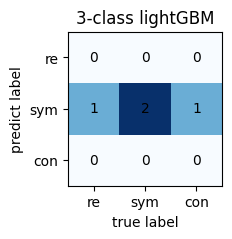

In [8]:
import lightgbm as lgb

model_name = 'lightGBM'

clf = lgb.LGBMClassifier(n_jobs=-1)
#clf.fit(train_x, train_y, sample_weight=class_weight.compute_sample_weight("balanced", train_y))
clf.fit(train_x, train_y)
result = clf.predict_proba(test_x)
#print(result)
y_pred = np.argmax(result,axis=1)

t = classification_report(test_y, y_pred, target_names=['re', 'sym', 'con'])
print(t)
confusion = confusion_matrix(test_y, y_pred)
ax = plt.figure(figsize=(2, 2))
#ax = sns.heatmap(confusion, fmt='.2f', cmap='Blues', annot=True)
ax = plt.imshow(confusion.T, cmap='Blues')
indices = range(len(confusion))
classes = ['re', 'sym', 'con']
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('3-class '  + model_name)

for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index],ha='center',va='center')
        #plt.text(first_index, second_index, np.round(float(confusion[first_index][second_index])/np.sum(confusion[first_index]),2),ha='center')
plt.savefig('../images/rna-dnam-merge-class3/CM_' + model_name,dpi=300, bbox_inches = 'tight')
plt.show()

              precision    recall  f1-score   support

          re       0.00      0.00      0.00         1
         sym       0.50      1.00      0.67         2
         con       0.00      0.00      0.00         1

    accuracy                           0.50         4
   macro avg       0.17      0.33      0.22         4
weighted avg       0.25      0.50      0.33         4



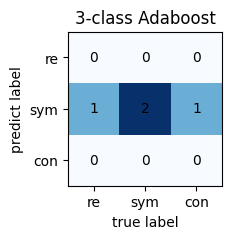

In [9]:
from sklearn.ensemble import AdaBoostClassifier

model_name = 'Adaboost'

clf = AdaBoostClassifier()
clf.fit(train_x, train_y)
#print(result)
y_pred = np.argmax(result,axis=1)

t = classification_report(test_y, y_pred, target_names=['re', 'sym', 'con'])
print(t)
confusion = confusion_matrix(test_y, y_pred)
ax = plt.figure(figsize=(2, 2))
#ax = sns.heatmap(confusion, fmt='.2f', cmap='Blues', annot=True)
ax = plt.imshow(confusion.T, cmap='Blues')
indices = range(len(confusion))
classes = ['re', 'sym', 'con']
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('3-class '  + model_name)

for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index],ha='center',va='center')
        #plt.text(first_index, second_index, np.round(float(confusion[first_index][second_index])/np.sum(confusion[first_index]),2),ha='center')
plt.savefig('../images/rna-dnam-merge-class3/CM_' + model_name,dpi=300, bbox_inches = 'tight')
plt.show()

              precision    recall  f1-score   support

          re       1.00      1.00      1.00         1
         sym       1.00      1.00      1.00         2
         con       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



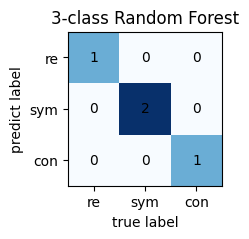

In [10]:
from sklearn.ensemble import RandomForestClassifier

model_name = 'Random Forest'

clf = RandomForestClassifier()
clf.fit(train_x, train_y)
result = clf.predict_proba(test_x)

#print(result)
y_pred = np.argmax(result,axis=1)

t = classification_report(test_y, y_pred, target_names=['re', 'sym', 'con'])
print(t)
confusion = confusion_matrix(test_y, y_pred)
ax = plt.figure(figsize=(2, 2))
#ax = sns.heatmap(confusion, fmt='.2f', cmap='Blues', annot=True)
ax = plt.imshow(confusion.T, cmap='Blues')
indices = range(len(confusion))
classes = ['re', 'sym', 'con']
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('3-class '  + model_name)

for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index],ha='center',va='center')
        #plt.text(first_index, second_index, np.round(float(confusion[first_index][second_index])/np.sum(confusion[first_index]),2),ha='center')
plt.savefig('../images/rna-dnam-merge-class3/CM_' + model_name,dpi=300, bbox_inches = 'tight')
plt.show()

              precision    recall  f1-score   support

          re       0.50      1.00      0.67         1
         sym       1.00      0.50      0.67         2
         con       1.00      1.00      1.00         1

    accuracy                           0.75         4
   macro avg       0.83      0.83      0.78         4
weighted avg       0.88      0.75      0.75         4



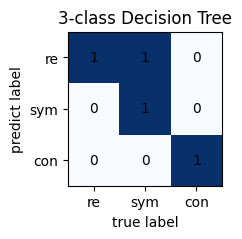

In [11]:
from sklearn.tree import DecisionTreeClassifier

model_name = 'Decision Tree'

clf = DecisionTreeClassifier()
clf.fit(train_x, train_y)
result = clf.predict_proba(test_x)
#print(result)
y_pred = np.argmax(result,axis=1)

t = classification_report(test_y, y_pred, target_names=['re', 'sym', 'con'])
print(t)
confusion = confusion_matrix(test_y, y_pred)
ax = plt.figure(figsize=(2, 2))
#ax = sns.heatmap(confusion, fmt='.2f', cmap='Blues', annot=True)
ax = plt.imshow(confusion.T, cmap='Blues')
indices = range(len(confusion))
classes = ['re', 'sym', 'con']
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('3-class '  + model_name)

for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index],ha='center',va='center')
        #plt.text(first_index, second_index, np.round(float(confusion[first_index][second_index])/np.sum(confusion[first_index]),2),ha='center')
plt.savefig('../images/rna-dnam-merge-class3/CM_' + model_name,dpi=300, bbox_inches = 'tight')
plt.show()

              precision    recall  f1-score   support

          re       1.00      1.00      1.00         1
         sym       1.00      1.00      1.00         2
         con       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



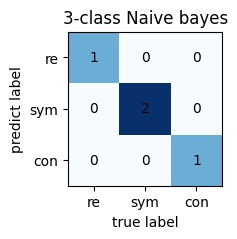

In [12]:
from sklearn.naive_bayes import GaussianNB

model_name = 'Naive bayes'

clf = GaussianNB()
clf.fit(train_x, train_y)
result = clf.predict_proba(test_x)
#print(result)
y_pred = np.argmax(result,axis=1)

t = classification_report(test_y, y_pred, target_names=['re', 'sym', 'con'])
print(t)
confusion = confusion_matrix(test_y, y_pred)
ax = plt.figure(figsize=(2, 2))
#ax = sns.heatmap(confusion, fmt='.2f', cmap='Blues', annot=True)
ax = plt.imshow(confusion.T, cmap='Blues')
indices = range(len(confusion))
classes = ['re', 'sym', 'con']
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('3-class '  + model_name)

for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index],ha='center',va='center')
        #plt.text(first_index, second_index, np.round(float(confusion[first_index][second_index])/np.sum(confusion[first_index]),2),ha='center')
plt.savefig('../images/rna-dnam-merge-class3/CM_' + model_name,dpi=300, bbox_inches = 'tight')
plt.show()

              precision    recall  f1-score   support

          re       0.50      1.00      0.67         1
         sym       1.00      1.00      1.00         2
         con       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.50      0.67      0.56         4
weighted avg       0.62      0.75      0.67         4



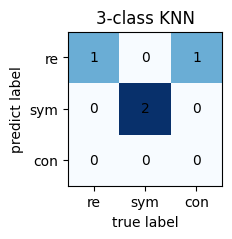

In [13]:
from sklearn.neighbors import KNeighborsClassifier

model_name = 'KNN'

clf = KNeighborsClassifier()
clf.fit(train_x, train_y)
result = clf.predict_proba(test_x)
#print(result)
y_pred = np.argmax(result,axis=1)

t = classification_report(test_y, y_pred, target_names=['re', 'sym', 'con'])
print(t)
confusion = confusion_matrix(test_y, y_pred)
ax = plt.figure(figsize=(2, 2))
#ax = sns.heatmap(confusion, fmt='.2f', cmap='Blues', annot=True)
ax = plt.imshow(confusion.T, cmap='Blues')
indices = range(len(confusion))
classes = ['re', 'sym', 'con']
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('3-class '  + model_name)

for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index],ha='center',va='center')
        #plt.text(first_index, second_index, np.round(float(confusion[first_index][second_index])/np.sum(confusion[first_index]),2),ha='center')
plt.savefig('../images/rna-dnam-merge-class3/CM_' + model_name,dpi=300, bbox_inches = 'tight')
plt.show()

              precision    recall  f1-score   support

          re       0.00      0.00      0.00         1
         sym       0.50      1.00      0.67         2
         con       0.00      0.00      0.00         1

    accuracy                           0.50         4
   macro avg       0.17      0.33      0.22         4
weighted avg       0.25      0.50      0.33         4



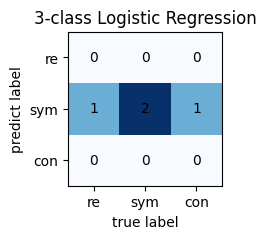

In [14]:
from sklearn.linear_model import LogisticRegression

model_name = 'Logistic Regression'

clf = LogisticRegression()
clf.fit(train_x, train_y)
result = clf.predict_proba(test_x)
#print(result)
y_pred = np.argmax(result,axis=1)

t = classification_report(test_y, y_pred, target_names=['re', 'sym', 'con'])
print(t)
confusion = confusion_matrix(test_y, y_pred)
ax = plt.figure(figsize=(2, 2))
#ax = sns.heatmap(confusion, fmt='.2f', cmap='Blues', annot=True)
ax = plt.imshow(confusion.T, cmap='Blues')
indices = range(len(confusion))
classes = ['re', 'sym', 'con']
plt.xticks(indices, classes)
plt.yticks(indices, classes)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('3-class '  + model_name)

for first_index in range(len(confusion)):
    for second_index in range(len(confusion[first_index])):
        plt.text(first_index, second_index, confusion[first_index][second_index],ha='center',va='center')
        #plt.text(first_index, second_index, np.round(float(confusion[first_index][second_index])/np.sum(confusion[first_index]),2),ha='center')
plt.savefig('../images/rna-dnam-merge-class3/CM_' + model_name,dpi=300, bbox_inches = 'tight')
plt.show()